In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import os
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle


def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:  # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
    path = os.path.join(test_path, '*g')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    print("Reading test images")
    for fl in files:
        flbase = os.path.basename(fl)
        img = cv2.imread(fl)
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
        X_test.append(img)
        X_test_id.append(flbase)

    ### because we're not creating a DataSet object for the test images, normalization happens here
    X_test = np.array(X_test, dtype=np.uint8)
    X_test = X_test.astype('float32')
    X_test = X_test / 255

    return X_test, X_test_id


class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1

            # # Shuffle the data (maybe)
            # perm = np.arange(self._num_examples)
            # np.random.shuffle(perm)
            # self._images = self._images[perm]
            # self._labels = self._labels[perm]
            # Start next epoch

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, ids, cls = load_train(train_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_ids = ids[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_ids = ids[validation_size:]
    train_cls = cls[validation_size:]

    data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
    data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets


def read_test_set(test_path, image_size):
    images, ids = load_test(test_path, image_size)
    return images, ids

In [4]:
import csv

# Path to the train.csv file
csv_file = 'train.csv'

# Read the CSV file and modify the labels
new_rows = []
with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Get the header row
    for row in csv_reader:
        filename, label = row[0], row[1]
        new_label = f'label_{label}'
        new_rows.append([filename, new_label])

# Write the updated CSV file
new_csv_file = 'new_train.csv'
with open(new_csv_file, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(header)
    csv_writer.writerows(new_rows)

print(f'New CSV file {new_csv_file} created with updated labels.')


New CSV file new_train.csv created with updated labels.


In [ ]:
#

In [13]:
import os
import csv
import shutil

# Path to the folder containing the original images
image_folder = 'train'

# Path to the new CSV file
new_csv_file = 'new_train.csv'

# Create a new folder to store renamed images
new_image_folder = 'train_new'
os.makedirs(new_image_folder, exist_ok=True)

# Read the new CSV file
with open(new_csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Get the header row
    counter = 1
    for row in csv_reader:
        filename, label = row[0], row[1]
        new_filename = f'{label}.{counter}.jpg'
        old_path = os.path.join(image_folder, filename)
        new_path = os.path.join(new_image_folder, new_filename)
        shutil.copy(old_path, new_path)
        print(f'Copied {filename} to {new_filename}')
        counter += 1

# Write the updated CSV file with the new image names and labels (same as before) let filename be train_list.csv , file_name is the updated name of the image
new_csv_file = 'train_list.csv'
with open(new_csv_file, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(header)
    for filename in os.listdir(new_image_folder):
        label = filename.split('.')[0]
        csv_writer.writerow([filename, label])




print(f'New folder "train_new" created with renamed images.')
print(f'New CSV file {new_csv_file} created with updated image names and labels.')


Copied Image_train_00001.jpg to label_0.1.jpg
Copied Image_train_00002.jpg to label_1.2.jpg
Copied Image_train_00003.jpg to label_0.3.jpg
Copied Image_train_00004.jpg to label_0.4.jpg
Copied Image_train_00005.jpg to label_0.5.jpg
Copied Image_train_00006.jpg to label_0.6.jpg
Copied Image_train_00007.jpg to label_0.7.jpg
Copied Image_train_00008.jpg to label_1.8.jpg
Copied Image_train_00009.jpg to label_0.9.jpg
Copied Image_train_00010.jpg to label_0.10.jpg
Copied Image_train_00011.jpg to label_0.11.jpg
Copied Image_train_00012.jpg to label_1.12.jpg
Copied Image_train_00013.jpg to label_0.13.jpg
Copied Image_train_00014.jpg to label_0.14.jpg
Copied Image_train_00015.jpg to label_0.15.jpg
Copied Image_train_00016.jpg to label_0.16.jpg
Copied Image_train_00017.jpg to label_0.17.jpg
Copied Image_train_00018.jpg to label_1.18.jpg
Copied Image_train_00019.jpg to label_0.19.jpg
Copied Image_train_00020.jpg to label_1.20.jpg
Copied Image_train_00021.jpg to label_0.21.jpg
Copied Image_train_000

In [14]:
import os
import csv
import shutil

# Path to the folder containing the images
image_folder = 'train_new'

# Path to the new filenames and labels CSV file
new_csv_file = 'train_list.csv'

# Create a new folder to store the separated dataset
separated_folder = 'separated_dataset'
os.makedirs(separated_folder, exist_ok=True)

# Read the new filenames and labels CSV file
with open(new_csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Get the header row
    for row in csv_reader:
        filename, label = row[0], row[1]
        class_folder = os.path.join(separated_folder, label)
        os.makedirs(class_folder, exist_ok=True)
        old_path = os.path.join(image_folder, filename)
        new_path = os.path.join(class_folder, filename)
        shutil.copy(old_path, new_path)
        print(f'Copied {filename} to {class_folder}')

print(f'Separated dataset created in the "{separated_folder}" folder.')


Copied label_0.1.jpg to separated_dataset\label_0
Copied label_0.10.jpg to separated_dataset\label_0
Copied label_0.100.jpg to separated_dataset\label_0
Copied label_0.10045.jpg to separated_dataset\label_0
Copied label_0.10067.jpg to separated_dataset\label_0
Copied label_0.101.jpg to separated_dataset\label_0
Copied label_0.1010.jpg to separated_dataset\label_0
Copied label_0.10185.jpg to separated_dataset\label_0
Copied label_0.102.jpg to separated_dataset\label_0
Copied label_0.10206.jpg to separated_dataset\label_0
Copied label_0.103.jpg to separated_dataset\label_0
Copied label_0.10383.jpg to separated_dataset\label_0
Copied label_0.104.jpg to separated_dataset\label_0
Copied label_0.10405.jpg to separated_dataset\label_0
Copied label_0.10442.jpg to separated_dataset\label_0
Copied label_0.10488.jpg to separated_dataset\label_0
Copied label_0.105.jpg to separated_dataset\label_0
Copied label_0.106.jpg to separated_dataset\label_0
Copied label_0.10682.jpg to separated_dataset\labe

In [15]:
#compare the size of the original and new folders
import os

# Path to the folder containing the original images
image_folder = 'train'

# Path to the new folder containing the renamed images
new_image_folder = 'train_new'

# Get the number of files in each folder
num_files_original = len(os.listdir(image_folder))
num_files_new = len(os.listdir(new_image_folder))

# Print the number of files in each folder
print(f'Number of files in {image_folder}: {num_files_original}')
print(f'Number of files in {new_image_folder}: {num_files_new}')


Number of files in train: 18391
Number of files in train_new: 18391


In [16]:
#check the length of train.csv
import csv

# Path to the train.csv file
csv_file = 'train.csv'

# Read the CSV file and count the number of rows
with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Skip the header row
    num_rows = sum(1 for _ in csv_reader)

print(f"Number of rows in train.csv: {num_rows}")


Number of rows in train.csv: 18391


In [17]:
import os
import random
import shutil

# Path to the train dataset folder
train_folder = 'train'

# Path to the new test dataset folder
test_folder = 'new_test'

# Percentage of images to be moved to the test dataset
test_percentage = 0.2  # Adjust this value as desired

# Create the new test dataset folder
os.makedirs(test_folder, exist_ok=True)

# Get the list of files in the train dataset folder
file_list = os.listdir(train_folder)

# Calculate the number of files to move to the test dataset
num_files = len(file_list)
num_test_files = int(num_files * test_percentage)

# Randomly select files to move to the test dataset
test_files = random.sample(file_list, num_test_files)

# Move the selected files to the test dataset folder
for file_name in test_files:
    src_path = os.path.join(train_folder, file_name)
    dst_path = os.path.join(test_folder, file_name)
    shutil.move(src_path, dst_path)
    print(f'Moved {file_name} to the test dataset')

print('Test dataset created successfully.')


Moved Image_train_04352.jpg to the test dataset
Moved Image_train_09832.jpg to the test dataset
Moved Image_train_08998.jpg to the test dataset
Moved Image_train_17795.jpg to the test dataset
Moved Image_train_18071.jpg to the test dataset
Moved Image_train_08524.jpg to the test dataset
Moved Image_train_15792.jpg to the test dataset
Moved Image_train_03721.jpg to the test dataset
Moved Image_train_12581.jpg to the test dataset
Moved Image_train_09790.jpg to the test dataset
Moved Image_train_06944.jpg to the test dataset
Moved Image_train_09050.jpg to the test dataset
Moved Image_train_13126.jpg to the test dataset
Moved Image_train_09021.jpg to the test dataset
Moved Image_train_03244.jpg to the test dataset
Moved Image_train_06385.jpg to the test dataset
Moved Image_train_06285.jpg to the test dataset
Moved Image_train_11418.jpg to the test dataset
Moved Image_train_11821.jpg to the test dataset
Moved Image_train_01145.jpg to the test dataset
Moved Image_train_17106.jpg to the test 

In [18]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'separated_dataset'
test_path = 'new_test'
checkpoint_dir = "models/"

In [19]:
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = read_test_set(test_path, img_size)

Reading training images
Loading label_0 files (Index: 0)
Loading label_1 files (Index: 1)
Loading label_2 files (Index: 2)
Loading label_3 files (Index: 3)
Loading label_4 files (Index: 4)
Loading label_5 files (Index: 5)
Loading label_6 files (Index: 6)
Reading test images


In [20]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		15449
- Test-set:		3678
- Validation-set:	2942


In [21]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

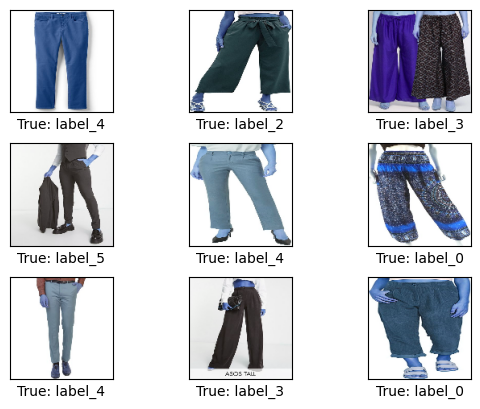

In [22]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [23]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [24]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [25]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [26]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [27]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [28]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [29]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])


In [30]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')


In [31]:
y_true_cls = tf.argmax(y_true, axis=1)


In [32]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [33]:
layer_conv1


<tf.Tensor 'Relu:0' shape=(?, 64, 64, 32) dtype=float32>

In [34]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [35]:
layer_conv2


<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 32) dtype=float32>

In [36]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [37]:
layer_conv3


<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

In [38]:
layer_flat, num_features = flatten_layer(layer_conv3)


In [39]:
layer_flat


<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

In [40]:
num_features


16384

In [41]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [42]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [43]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [44]:
layer_fc2


<tf.Tensor 'add_4:0' shape=(?, 7) dtype=float32>

In [45]:
y_pred = tf.nn.softmax(layer_fc2)


In [46]:
y_pred_cls = tf.argmax(y_pred, axis=1)


In [47]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)


In [48]:
cost = tf.reduce_mean(cross_entropy)


In [49]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


In [50]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


In [51]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [52]:
session = tf.Session()


In [53]:
session.run(tf.global_variables_initializer())


In [54]:
train_batch_size = batch_size


In [55]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [56]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [57]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

In [58]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [59]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):
    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Calculate the number of batches based on the batch size.
    batch_size = 32
    num_batches = (num_test + batch_size - 1) // batch_size

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Iterate over the batches
    for batch in range(num_batches):
        # Calculate the start and end index for the current batch
        i = batch * batch_size
        j = min((batch + 1) * batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        batch_size_actual = j - i  # Adjust batch size for the last batch

        # Reshape the images to the correct shape
        images = images.reshape(batch_size_actual, -1)

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred])

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)


In [60]:
optimize(num_iterations=1)
print_validation_accuracy()

Epoch 1 --- Training Accuracy:   9.4%, Validation Accuracy:  21.9%, Validation Loss: 1.928
Time elapsed: 0:00:00


C:\Users\cheth\AppData\Local\Temp\ipykernel_9160\3242141547.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 13.1% (385 / 2942)


In [61]:
optimize(num_iterations=99)  # We already performed 1 iteration above.


Time elapsed: 0:00:16


C:\Users\cheth\AppData\Local\Temp\ipykernel_9160\3242141547.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 28.4% (835 / 2942)
Example errors:


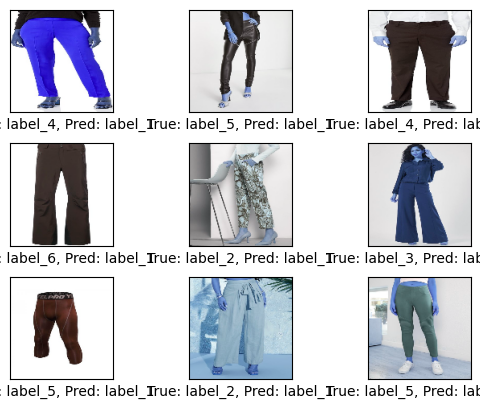

In [62]:
print_validation_accuracy(show_example_errors=True)


In [63]:
optimize(num_iterations=900)  # We performed 100 iterations above.


Epoch 2 --- Training Accuracy:  21.9%, Validation Accuracy:  46.9%, Validation Loss: 1.556
Epoch 3 --- Training Accuracy:  25.0%, Validation Accuracy:  37.5%, Validation Loss: 1.650
Time elapsed: 0:02:25


C:\Users\cheth\AppData\Local\Temp\ipykernel_9160\3242141547.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 42.2% (1242 / 2942)
Example errors:


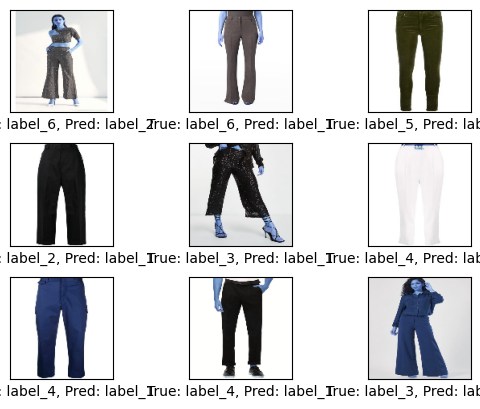

In [64]:
print_validation_accuracy(show_example_errors=True)


In [102]:
optimize(num_iterations=9000) # We performed 1000 iterations above.


Epoch 41 --- Training Accuracy:  81.2%, Validation Accuracy:  59.4%, Validation Loss: 2.492
Epoch 42 --- Training Accuracy:  84.4%, Validation Accuracy:  62.5%, Validation Loss: 1.842
Epoch 43 --- Training Accuracy:  87.5%, Validation Accuracy:  59.4%, Validation Loss: 2.465
Epoch 44 --- Training Accuracy:  90.6%, Validation Accuracy:  43.8%, Validation Loss: 2.634
Epoch 45 --- Training Accuracy:  96.9%, Validation Accuracy:  43.8%, Validation Loss: 1.898
Epoch 46 --- Training Accuracy:  96.9%, Validation Accuracy:  50.0%, Validation Loss: 2.412
Epoch 47 --- Training Accuracy:  93.8%, Validation Accuracy:  62.5%, Validation Loss: 2.132
Epoch 48 --- Training Accuracy:  96.9%, Validation Accuracy:  40.6%, Validation Loss: 3.801
Epoch 49 --- Training Accuracy:  90.6%, Validation Accuracy:  65.6%, Validation Loss: 2.204
Epoch 50 --- Training Accuracy:  96.9%, Validation Accuracy:  50.0%, Validation Loss: 3.213
Epoch 51 --- Training Accuracy:  93.8%, Validation Accuracy:  59.4%, Validation 

In [103]:
#assign the trained weights to a new variable and save it as model.ckpt
#saver = tf.train.Saver()
#save_path = saver.save(session, "model.ckpt")
#print("Model saved in file: %s" % save_path)
    

C:\Users\cheth\AppData\Local\Temp\ipykernel_9160\3242141547.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)


Accuracy on Test-Set: 53.6% (1576 / 2942)
Example errors:


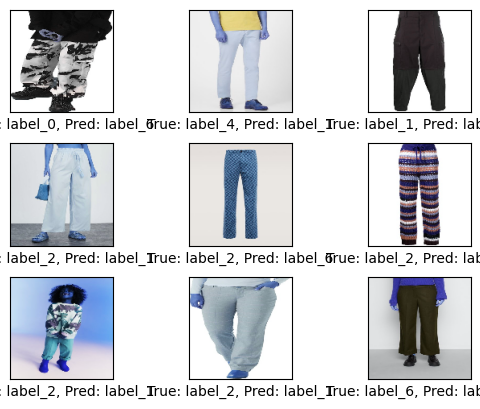

Confusion Matrix:
[[ 80  99  29  12   6   4   7]
 [ 37 571  52  12  91  52  20]
 [ 40 203 246  85  39   8  49]
 [ 12  20  47 211   5   2  25]
 [  2 120  17   6 151   6  16]
 [  6 110   1   1  12 109   9]
 [  3  38  24  20  16   3 208]]


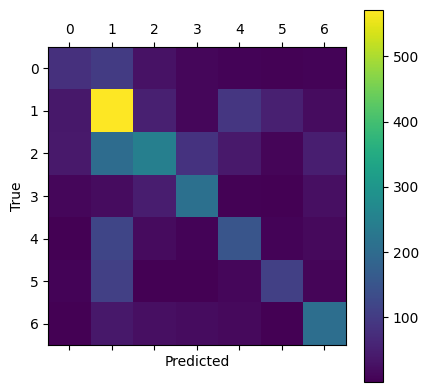

In [104]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)


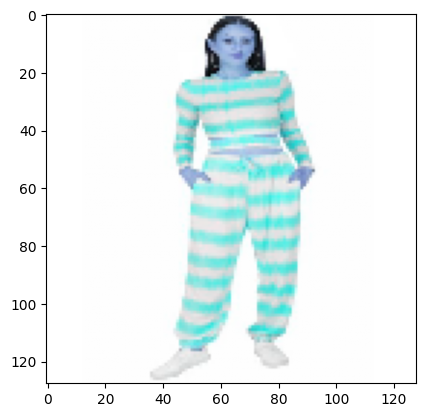

In [105]:


test_0 = cv2.imread('separated_dataset\label_0\label_0.3.jpg')
test_0 = cv2.resize(test_0, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_1 = plt.imshow(test_0.reshape(img_size, img_size, num_channels))

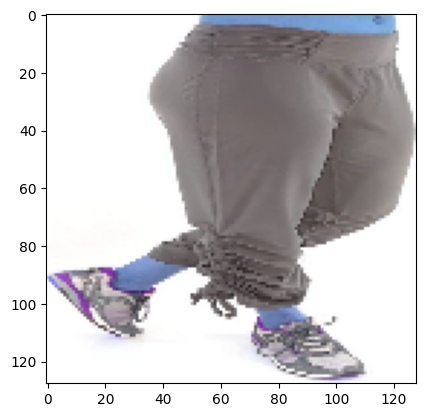

In [106]:

test_1 = cv2.imread('separated_dataset\label_1\label_1.8.jpg')
test_1 = cv2.resize(test_1, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_1 = plt.imshow(test_1.reshape(img_size, img_size, num_channels))

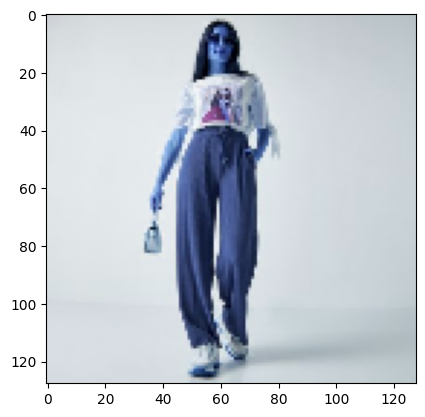

In [107]:
test_2 = cv2.imread('separated_dataset\label_2\label_2.29.jpg')
test_2 = cv2.resize(test_2, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_2 = plt.imshow(test_2.reshape(img_size, img_size, num_channels))


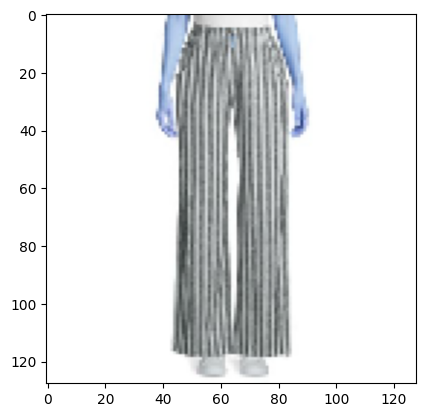

In [108]:
test_3 = cv2.imread('separated_dataset\label_3\label_3.1795.jpg')
test_3 = cv2.resize(test_3, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_3 = plt.imshow(test_3.reshape(img_size, img_size, num_channels))


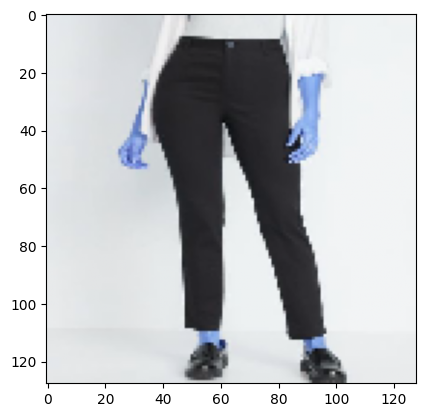

In [109]:
test_4 = cv2.imread('separated_dataset\label_4\label_4.800.jpg')
test_4 = cv2.resize(test_4, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_4 = plt.imshow(test_4.reshape(img_size, img_size, num_channels))


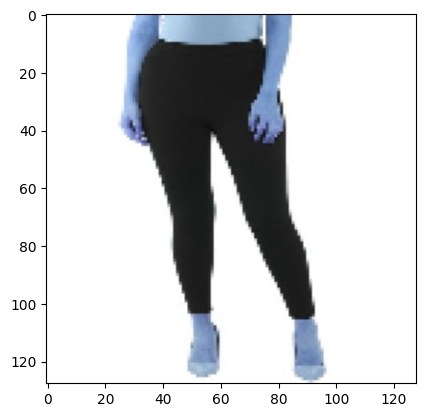

In [110]:
test_5 = cv2.imread('separated_dataset\label_5\label_5.2828.jpg')
test_5 = cv2.resize(test_5, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_5 = plt.imshow(test_5.reshape(img_size, img_size, num_channels))


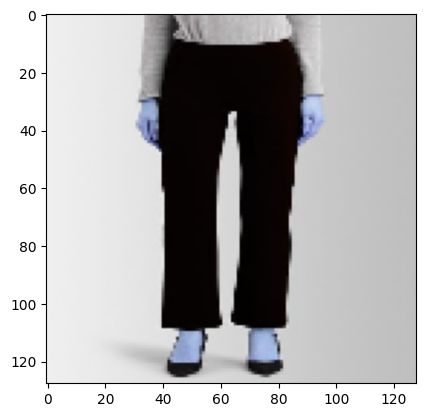

In [111]:
test_6 = cv2.imread('separated_dataset\label_6\label_6.1945.jpg')
test_6 = cv2.resize(test_6, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_6 = plt.imshow(test_6.reshape(img_size, img_size, num_channels))


In [112]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[0, 0, 0, 0, 0, 0, 0]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_0: {}".format(sample_prediction(test_0)))
print("Predicted class for test_1: {}".format(sample_prediction(test_1)))
print("Predicted class for test_2: {}".format(sample_prediction(test_2)))
print("Predicted class for test_3: {}".format(sample_prediction(test_3)))
print("Predicted class for test_4: {}".format(sample_prediction(test_4)))
print("Predicted class for test_5: {}".format(sample_prediction(test_5)))
print("Predicted class for test_6: {}".format(sample_prediction(test_6)))


Predicted class for test_0: label_0
Predicted class for test_1: label_1
Predicted class for test_2: label_2
Predicted class for test_3: label_3
Predicted class for test_4: label_1
Predicted class for test_5: label_5
Predicted class for test_6: label_4


In [113]:
#load sample_submission.csv
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head(5)

file_name  label
0  Image_test_00001.jpg      0
1  Image_test_00002.jpg      0
2  Image_test_00003.jpg      0
3  Image_test_00004.jpg      0
4  Image_test_00005.jpg      0

In [114]:
#drop label column
sample_submission.drop('label', axis=1, inplace=True)
#save the dataframe to a csv file
sample_submission.to_csv('sample_submission_1.csv', index=False)

In [115]:
#load model.ckpt
#saver.restore(session, save_path='model.ckpt')


In [116]:

import os
import csv
import cv2
import numpy as np

# Path to the test images folder
test_folder = 'test'

# Path to the CSV file containing the file names
csv_file = 'sample_submission_1.csv'

# Path to save the results CSV file
results_file = 'results.csv'

# Function to make predictions on a single test image
# Function to make predictions on a single test image
def sample_prediction(test_im):
    # Resize the test image
    test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255.0
    test_im = test_im.reshape(1, img_size_flat)

    # Run the session and make a prediction
    feed_dict_test = {x: test_im}
    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Return the predicted class
    return classes[test_pred[0]]

# Create a list to store the predictions
results = []

# Open the results file in append mode
with open(results_file, 'a') as f:
    # Create a CSV writer
    writer = csv.writer(f)
    #add header to the csv file
    writer.writerow(['file_name', 'label'])
    # Loop over the test images
    for img in os.listdir(test_folder):
        # Read the image
        test_im = cv2.imread(os.path.join(test_folder, img))
        # Make prediction
        pred = sample_prediction(test_im)
        # Append the filename and the prediction to the results list
        results.append([img, pred])
        # Write the result to the results file
        writer.writerow([img, pred])

# Print the results
print(results)



[['Image_test_00001.jpg', 'label_2'], ['Image_test_00002.jpg', 'label_2'], ['Image_test_00003.jpg', 'label_2'], ['Image_test_00004.jpg', 'label_1'], ['Image_test_00005.jpg', 'label_6'], ['Image_test_00006.jpg', 'label_3'], ['Image_test_00007.jpg', 'label_4'], ['Image_test_00008.jpg', 'label_0'], ['Image_test_00009.jpg', 'label_3'], ['Image_test_00010.jpg', 'label_1'], ['Image_test_00011.jpg', 'label_1'], ['Image_test_00012.jpg', 'label_3'], ['Image_test_00013.jpg', 'label_1'], ['Image_test_00014.jpg', 'label_3'], ['Image_test_00015.jpg', 'label_4'], ['Image_test_00016.jpg', 'label_1'], ['Image_test_00017.jpg', 'label_1'], ['Image_test_00018.jpg', 'label_1'], ['Image_test_00019.jpg', 'label_2'], ['Image_test_00020.jpg', 'label_1'], ['Image_test_00021.jpg', 'label_1'], ['Image_test_00022.jpg', 'label_1'], ['Image_test_00023.jpg', 'label_1'], ['Image_test_00024.jpg', 'label_1'], ['Image_test_00025.jpg', 'label_6'], ['Image_test_00026.jpg', 'label_3'], ['Image_test_00027.jpg', 'label_1'], 

In [117]:
#load results.csv
results = pd.read_csv('results.csv')
results.head(5)


file_name    label
0  Image_test_00001.jpg  label_2
1  Image_test_00002.jpg  label_2
2  Image_test_00003.jpg  label_2
3  Image_test_00004.jpg  label_1
4  Image_test_00005.jpg  label_6

In [118]:
#load results.csv
results = pd.read_csv('results.csv')
results.head(5)


file_name    label
0  Image_test_00001.jpg  label_2
1  Image_test_00002.jpg  label_2
2  Image_test_00003.jpg  label_2
3  Image_test_00004.jpg  label_1
4  Image_test_00005.jpg  label_6

In [119]:
#replace the label column eg label_0 with 0 and so on
results['label'] = results['label'].replace(['label_0'], 0)
results['label'] = results['label'].replace(['label_1'], 1)
results['label'] = results['label'].replace(['label_2'], 2)
results['label'] = results['label'].replace(['label_3'], 3)
results['label'] = results['label'].replace(['label_4'], 4)
results['label'] = results['label'].replace(['label_5'], 5)
results['label'] = results['label'].replace(['label_6'], 6)


#save the dataframe to a csv file
results.to_csv('results_1.csv', index=False)
